Imports

In [144]:
from collections import defaultdict
from collections import Counter
from wordcloud import WordCloud
import os
import yake
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from IPython.display import Image
import spacy
from spacy.lang.fr.examples import sentences
import fr_core_news_md
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bao13\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Ulb\tac\tac_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [145]:
nlp = spacy.load('fr_core_news_md')

In [146]:
tokenizer = AutoTokenizer.from_pretrained("tblard/tf-allocine", use_pt=False)
model = TFAutoModelForSequenceClassification.from_pretrained("tblard/tf-allocine")

sentiment_analyser = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at tblard/tf-allocine.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Device set to use 0


Etape 2: Choisir une année entre 1887 et 1970

In [147]:
year = 1887

Etape 3: Extraire les mots clés relatives à l'année choisie

In [148]:
# Instantier l'extracteur de mots clés
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

In [149]:
# Lister les fichiers de cette année
data_path = '../../data'
txt_path = '../../data/txt'
year_files = [f for f in os.listdir(txt_path) if os.path.isfile(os.path.join(txt_path, f)) and str(year) in f]
len(year_files) 


36

In [150]:
#Extraction des mots clés
kept = []
for f in sorted(year_files):
    text = open(os.path.join(txt_path, f), 'r', encoding="utf-8").read()
    keywords = kw_extractor.extract_keywords(text)
    for kw, score in keywords:
        kept.append(kw)
print(kept)


['EXEMPLAIRES distribués gratuitement', 'lomération bruxelloise et.en', 'EXEMPLAIRES distribués', 'bruxelloise et.en province', 'assassins politiques', 'distribués gratuitement', 'lomération bruxelloise', 'bruxelloise et.en', 'QUOTIDIEN GRATUIT Température', 'qu’il', 'ASSASSINS', 'Température Baromètre Humidité', 'midi Température Baromètre', 'ræge quotidien', 'commis', 'fut', 'chemin de fer', 'Louvel', 'd’une', 'uno', 'chemin', 'fer', 'société', 'heures', 'EXEMPLAIRES', 'BRUXELLES', 'travail', 'politiques', 'midi', 'Décembre', 'jour', 'ligne', 'grand', 'point', 'd’un', 'SIÈCLE', 'GRATUIT Température maximum', 'ans', 'commis au chemin', 'Jeudi', 'Morey et Pépin', 'capitaine', 'annonces', 'timbre', 'homme', 'QUOTIDIEN GRATUIT', 'GRATUIT Température', 'facteur rural', 'mort', 'Température Baromètre', 'Ligue nalio', 'combat', 'quo', 'heures', 'rue', 'ance à rester', 'rester fidèle', 'fidèle aux priacipes', 's’est', 'police', 'd’une', 'qu’il', 'j’ai', 'maison', 'n’ai', 'mort', 'directeur',

Etape 4: Faire une liste de stopwords + générer un nuage de mot

In [151]:
# Stopwords (Idem que dans s1)
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "rossel", "dem", 
       "ilàgg", "lomération", "année", "ans", "très", "quo", "chez", "etc", "mois", "plusieurs"
       "mme", "elles", "près", "quand", "toute", "alors", "car", "assez", "avant", "celui", "leurs", "oui", "scs",
       "font", "plusieurs","ici","fit","jamais","trop", "puis", "enfin", "fin", "nommé","peu","aujourd",
       "mis","tant","dix","uno","lés","pris","déjà","aller", "quelques"]
sw = set(sw)

In [152]:
# Ecrire dans un fichier temporaire pour trouver les déchets

# Stocker le contenu de ces fichiers dans une liste
content_list = []
for txt in year_files:
    with open(os.path.join('../../data/txt', txt), 'r', encoding='utf-8') as f:
        content_list.append(f.read())
        
# Ecrire tout le contenu dans un fichier temporaire
temp_path = '../../data/tmp'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)
with open(os.path.join(temp_path, f'{year}.txt'), 'w', encoding='utf-8') as f:
    f.write(' '.join(content_list))



In [153]:
# Fonction de nettoyage
def clean_text(year, folder=None):
    if folder is None:
        input_path = f"{year}.txt"
        output_path = f"{year}_clean.txt"
    else:
        input_path = f"{folder}/{year}.txt"
        output_path = f"{folder}/{year}_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, 'r', encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.upper() for w in words if len(w) > 2 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [154]:
# Application de la fonction de nettoyage
clean_text(year, folder=temp_path)

# Vérifier le résultat
with open(os.path.join(temp_path, f'{year}_clean.txt'), 'r', encoding='utf-8') as f:
    after = f.read()



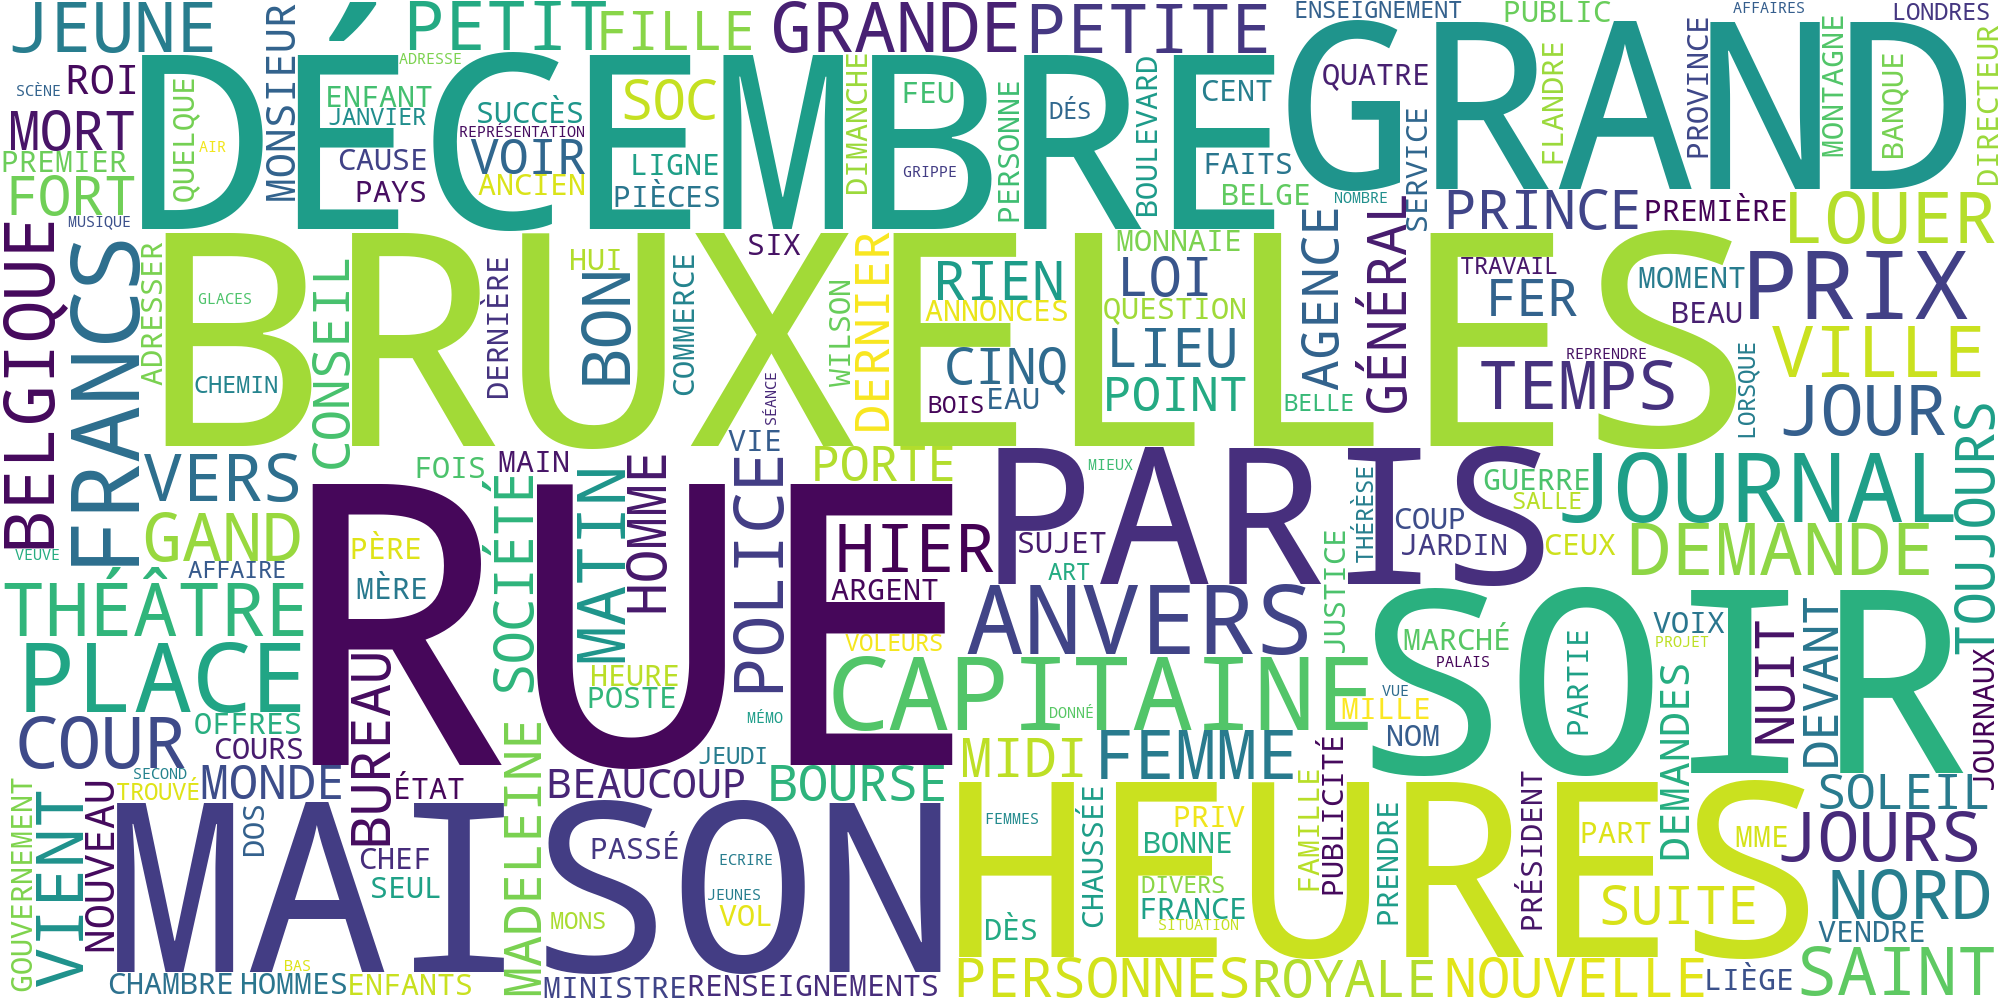

In [155]:
frequencies = Counter(after.split())
cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
cloud.to_file(os.path.join(temp_path, f"{year}.png"))
Image(filename=os.path.join(temp_path, f"{year}.png"))

Etape 5: Trouver les entités nommées principales pertinents pour cette année

In [156]:
# Charger le texte
n=1000000
text = open(f"../../data/tmp/{year}.txt", encoding='utf-8').read()[:n]


# Traiter le texte

doc = nlp(text)

In [157]:
# Compter les entités
people = defaultdict(int)
for ent in doc.ents:
    if (ent.label_ == "PER" or ent.label_ == "ORG" or ent.label_ == "LOC" or ent.label_ == "MISC" ) and len(ent.text) > 3:
        people[ent.text] += 1

In [158]:
# Trier et imprimer

sorted_people = sorted(people.items(), key=lambda kv: kv[1], reverse=True)

for person, freq in sorted_people[:50]:
    print(f"{person} apparait {freq} fois dans le corpus")

Bruxelles apparait 142 fois dans le corpus
Paris apparait 94 fois dans le corpus
Belgique apparait 46 fois dans le corpus
Anvers apparait 42 fois dans le corpus
Nord apparait 33 fois dans le corpus
rue de la Madeleine apparait 32 fois dans le corpus
Gand apparait 25 fois dans le corpus
Russie apparait 25 fois dans le corpus
Londres apparait 24 fois dans le corpus
Thérèse apparait 23 fois dans le corpus
Guilbert apparait 22 fois dans le corpus
Liège apparait 21 fois dans le corpus
SOIR apparait 21 fois dans le corpus
Bourse apparait 20 fois dans le corpus
Gioconda apparait 20 fois dans le corpus
Rossel apparait 19 fois dans le corpus
rue Royale apparait 18 fois dans le corpus
Enguerrand apparait 18 fois dans le corpus
Vienne apparait 17 fois dans le corpus
Monnaie apparait 17 fois dans le corpus
Flénu apparait 16 fois dans le corpus
Grippe-Soleil apparait 16 fois dans le corpus
Brux apparait 15 fois dans le corpus
M. Wilson apparait 15 fois dans le corpus
Allemagne apparait 15 fois dans

Etape 6: Créer un tableau de polarité et de subjectivité de 10 phrases des articles

In [159]:
# Sélection arbitraire de 10 phrases 

sentences = ["Elles allaient prendre ces repas aux fourneaux économiques de la Société coopérative alimentaire.",
             "Elles y reposeront sur des lits de fer, garnis de matelas, de draps et de couvertures.",
             "La Reine qui, vous ne l’ignorez pas, aime fort le théâtre, regrette vivement de ne pouvoir être ici ce soir.",
             "Le gouvernement de ce pays a décidé de licencier la gendarmerie dans tout le royaume, par mesure d’économie.",
             "Nous avons encore pas mal de chemin à faire avant d’en arriver là !",
             "Kilraine et Smith quittent paletot, gilet, chemise, en un mot, se mettent nus jusqu’à la ceinture, malgré une pluie mêlée de neige et un vent assez aigre.",
             "Au surplus, il est bien certain que Louvel n’était pas foncièrement un fort méchant homme.",
             "Il avait combattu le comte Eudes et RoberMe-Fort, sous les murs de Paris.",
             "On ne parle dans le haut de la ville, du côté de la porte de Louvain, que d’une affaire de mœurs des plus scandaleuses.",
             "Le roi Louis-Philippe fut, de tous les souverains du siècle, celui que les assassins politiques menacèrent le plus."]

In [160]:
# Analyse de sentiment à l'aide de Textblobfr

# Fonction 

tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

def get_sentiment(input_text):
    blob = tb(input_text)
    polarity, subjectivity = blob.sentiment
    polarity_perc = f"{100*abs(polarity):.0f}"
    subjectivity_perc = f"{100*subjectivity:.0f}"
    if polarity > 0:
        polarity_str = f"{polarity_perc}% positive"
    elif polarity < 0:
        polarity_str = f"{polarity_perc}% negative"
    else:
        polarity_str = "neutral"
    if subjectivity > 0:
        subjectivity_str = f"{subjectivity_perc}% subjective"
    else:
        subjectivity_str = "perfectly objective"
    print(f"This text is {polarity_str} and {subjectivity_str}.")

In [161]:
# Application de la fonction sur les phrases choisis

for sentence in sentences:
    get_sentiment(sentence)

This text is 10% positive and perfectly objective.
This text is neutral and perfectly objective.
This text is 5% positive and 45% subjective.
This text is 16% positive and 30% subjective.
This text is 44% positive and 70% subjective.
This text is 2% positive and 23% subjective.
This text is 7% positive and 26% subjective.
This text is neutral and perfectly objective.
This text is 41% negative and 60% subjective.
This text is 9% positive and 5% subjective.


In [165]:
# Analyse à l'aide de transformers

for sentence in sentences:
    print(sentiment_analyser(sentence))

[{'label': 'NEGATIVE', 'score': 0.7611846327781677}]
[{'label': 'NEGATIVE', 'score': 0.5873062014579773}]
[{'label': 'NEGATIVE', 'score': 0.7466298341751099}]
[{'label': 'NEGATIVE', 'score': 0.631074070930481}]
[{'label': 'NEGATIVE', 'score': 0.8687559366226196}]
[{'label': 'NEGATIVE', 'score': 0.5531622767448425}]
[{'label': 'NEGATIVE', 'score': 0.6045989394187927}]
[{'label': 'POSITIVE', 'score': 0.7582283020019531}]
[{'label': 'NEGATIVE', 'score': 0.8481392860412598}]
[{'label': 'POSITIVE', 'score': 0.8261762857437134}]
